<a href="https://colab.research.google.com/github/vlad-uve/CAE-MNIST/blob/main/notebooks/CAE_tradeoff_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Autoencoder (CAE) — Trade-off Model**

This notebook defines, trains, and evaluates a streamlined Convolutional Autoencoder (CAE) that balances reconstruction quality with model compactness and computational efficiency. It is designed for lightweight tasks such as MNIST digit reconstruction, where performance must be maintained without excessive architectural overhead.

---

## 📌 Objective

To implement the key findings from the experimental CAE architectures to create a compact CAE that preserves reconstruction quality while minimizing the number of parameters and compactly encoding input MNIST images, hence, providing an efficient alternative to the baseline model.

---

## 🔁 Experiment Workflow

1. Clone the project and configure dependencies  
2. Define the trade-off model architecture  
3. Train the model over 20 epochs using the Adam optimizer   
4. Analyze training and validation losses, and evaluate reconstruction quality
5. Make conclusion
6. Export results to GitHub

---

## 📊 Key Findings


## 1. 🔧 Setup

This section setups and configure project dependencies.

- Clone the GitHub repository  
- Import model classes and utility functions from `src/`  
- Import necessary libraries
- Define constants

## 2. 🧠 Define Trade-Off Model

This section defines the Trade-Off CAE architecture, designed to reduce complexity while maintaining strong reconstruction performance:

- **Convolutional filters:** `[32, 32]` (shallower and narrower configuration)  
- **Latent dimension:** `16` (reduced for more compact representation)  
- **Depth:** 2 convolutional blocks in both encoder and decoder  

The following settings remain consistent with the baseline for controlled comparison:

- Batch sizes: 32 (train) / 500 (validation)  
- Activation: ReLU  
- Optimizer: Adam (`lr = 1e-3`)  
- Scheduler: `ReduceLROnPlateau`  
- Epochs: 20  

## 3. 🏋️‍♀️ Model Training

This section trains the trade-off model using the `run_model_training()` function. The function encapsulates the full training loop, including validation checks, learning rate scheduling, and result tracking.

- Trained for `base_num_epoch = 20` epochs  
- Tracked both training and validation loss at each step  
- Applied `ReduceLROnPlateau` scheduler on validation loss  
- Saved model weights and training history

## 4. 🔍 Results and Observations

This section summarizes the training dynamics and reconstruction performance of the trade-off CAE model.

### 4.1 📉 Loss Curve Analysis

- Training and validation losses for the trade-off model decreased steadily and converged early, indicating **stable and reliable learning dynamics**  
- Although the loss curve remain consistently **above the baseline**, the difference is **minor and does not significantly affect reconstruction quality**  
- The overall trend suggests that the model is well-matched to the task complexity, with **no signs of overfitting** and good generalization performance  


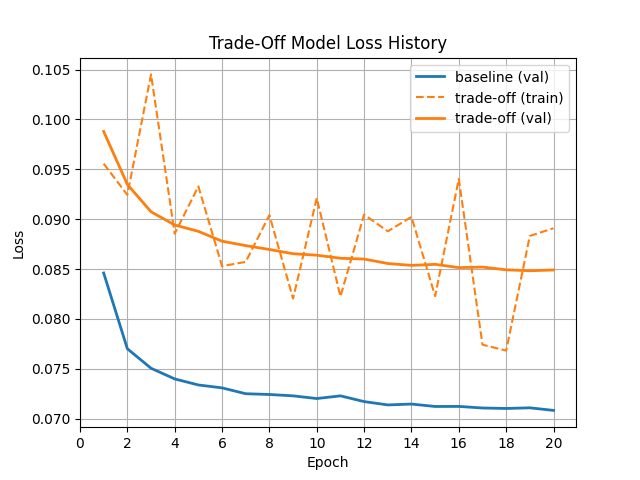

In [29]:
display(Image(filename='/content/CAE-MNIST/outputs/tradeoff_model_files/tradeoff_image_loss.png'))

### 4.2 📷 Reconstruction Quality Analysis

- **Reconstruction quality is high and consistent**, with all digits clearly recognizable  
- Key visual features such as **shapes, edges, and loops are well preserved**, demonstrating effective encoding and decoding  
- While minor differences exist compared to the baseline, they are **subtle and do not materially impact the output**  
- The trade-off model performs **nearly as well as the baseline**, despite having a significantly lighter and less complex architecture  

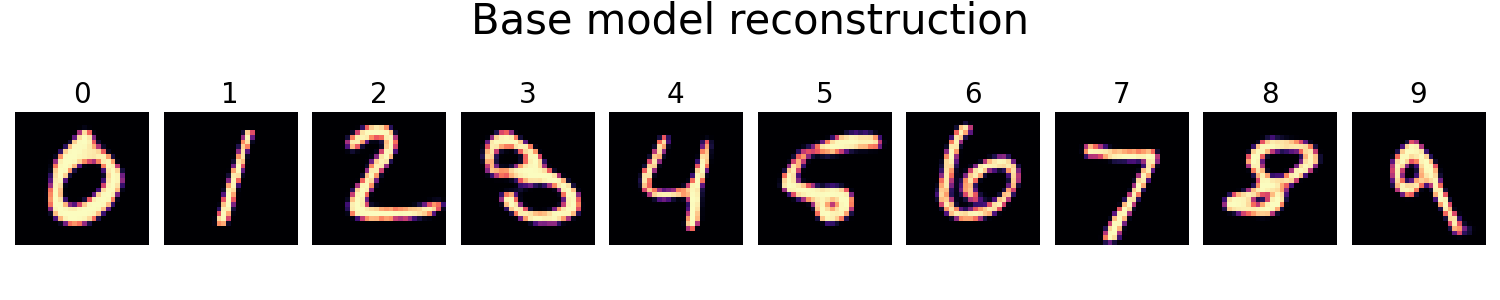

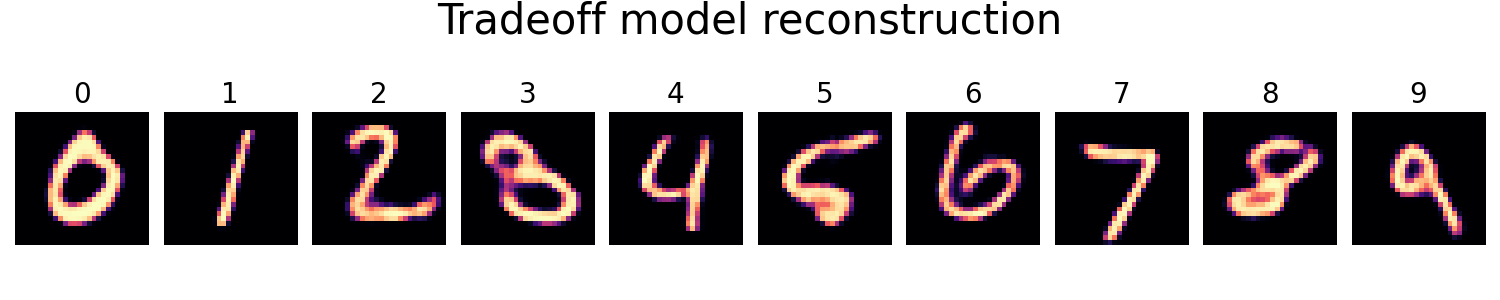

In [30]:
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))
display(Image(filename='/content/CAE-MNIST/outputs/tradeoff_model_files/tradeoff_image_reconstruction.png'))

### 4.3 🧮 Model Complexity Analysis

The total number of trainable parameters in the trade-odd CAE is almost twice as fewer than in the baseline model - 86k vs 137k. Therefore, model complexity was successfully reduced.

📊 **Trade-Off Model Total Parameters**: ~86K
📊 **BAseline Model Total Parameters**: ~137K

## 5. ✅ Conclusion

The trade-off model demonstrates **stable training behavior**, with smooth loss convergence and no signs of overfitting. While its loss values are slightly higher than those of the baseline, the difference is minor and does not noticeably affect reconstruction quality.

Reconstructed digits remain **highly recognizable**, with key visual features accurately preserved. This confirms that the model performs the task **nearly as well as the baseline**, despite using fewer layers and a smaller latent space.

Importantly, the trade-off model has **roughly half the parameter count** of the baseline (~0.7M vs. ~1.2M), resulting in a lighter and more efficient architecture.

Given its performance and efficiency, this model represents the **most optimal configuration** for the MNIST CAE task — achieving a strong balance between quality, compactness, and simplicity.

---
---

# 🛠️ Notebook Workflow

The sections below contain the actual code used to define, train, and evaluate the baseline CAE. This includes model setup, training logic, and result generation. These blocks serve as the working core of the notebook and support the summary presented above.


## 1. 🔧 Setup

In [1]:
from getpass import getpass

# get repo url
token = getpass("Paste your GitHub token")
user_name = 'vlad-uve'
repo_name = 'CAE-MNIST'
repo_url = f"https://{token}@github.com/{user_name}/{repo_name}.git"

# clone the repo
!git config --global user.email "vladislav.yushkevich.uve@gmail.com"
!git config --global user.name "vlad_uve"
!git clone {repo_url}

# append system path
import sys
sys.path.append('/content/CAE-MNIST')

Paste your GitHub token··········
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 983, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 983 (delta 51), reused 39 (delta 23), pack-reused 898 (from 1)
Receiving objects: 100% (983/983), 26.19 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (544/544), done.


In [2]:
# import core model components
from src.model import AutoEncoder, Encoder, Decoder

# import training utilities
from src.train import train_model, validate_model, run_model_training

# import data loading functions
from src.data import get_train_dataloader, get_validation_dataloader

# import evaluation helpers
from src.evaluation import get_experiment_reconstructions, get_image_samples

# import plotting functions
from src.plotting import plot_digits_row, plot_experiment_reconstructions, plot_experiment_history

In [3]:
# OS and file utilities
import os
import shutil

# PyTorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data loading and transformations
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Model summary utility
from torchsummary import summary

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plotting
import matplotlib.pyplot as plt

from IPython.display import Image, display

In [4]:
# set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

## 2. 🧠 Define Trade-Off Model

### 2.1 Define New CAE Class

In [5]:
class TradeoffEncoder(Encoder):
    def _build_layers(self):
        # 2-layer encoder architecture
        self.encn1 = nn.Conv2d(1, self.n_channels[0], self.kernel[0], self.stride, self.padding)
        self.encn2 = nn.Conv2d(self.n_channels[0], self.n_channels[1], self.kernel[1], self.stride, self.padding)

        # optional batch normalization layers after each conv
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[0])
            self.bn2 = nn.BatchNorm2d(self.n_channels[1])
        else:
            self.bn1 = self.bn2 = nn.Identity()

        # flatten and fully connected bottleneck layer
        # assumes output is 7x7 after 2 conv layers on 28x28 input
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.n_channels[1] * 7 * 7, self.latent_dim)

    def forward(self, input_x):
        x = self.apply_activation(self.bn1(self.encn1(input_x)))
        x = self.apply_activation(self.bn2(self.encn2(x)))
        return self.fc1(self.flatten(x))



class TradeoffDecoder(Decoder):
    def _build_layers(self):
        # fully connected + unflatten to prepare for decoding
        self.fc1 = nn.Linear(self.latent_dim, self.n_channels[1] * 7 * 7)
        self.unflatten = nn.Unflatten(1, (self.n_channels[1], 7, 7))

        # 2-layer decoder architecture (reverse of encoder)
        self.decn1 = nn.ConvTranspose2d(self.n_channels[1], self.n_channels[0], self.kernel[1], self.stride, self.padding)
        self.decn2 = nn.ConvTranspose2d(self.n_channels[0], 1, self.kernel[0], self.stride, self.padding)

        # optional batch normalization
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[1])
        else:
            self.bn1 = nn.Identity()

    def forward(self, encoded):
        x = self.unflatten(self.fc1(encoded))
        x = self.apply_activation(self.bn1(self.decn1(x)))
        x = self.decn2(x)
        return torch.sigmoid(x)  # use torch.sigmoid, not F.sigmoid



class TradeoffAutoEncoder(nn.Module):
    def __init__(self, n_channels, latent_dim, use_batch_norm=False, activation_func='relu', leaky_relu_slope=0.2):
        super(TradeoffAutoEncoder, self).__init__()

        kernel = [4, 4]
        stride = 2
        padding = 1

        self.encoder = TradeoffEncoder(n_channels, latent_dim, kernel, stride, padding,
                                      use_batch_norm, activation_func, leaky_relu_slope)
        self.decoder = TradeoffDecoder(n_channels, latent_dim, kernel, stride, padding,
                                      use_batch_norm, activation_func, leaky_relu_slope)

    def forward(self, input_x):
        encoded_x = self.encoder(input_x)
        decoded_x = self.decoder(encoded_x)
        return decoded_x, encoded_x

### 2.2 Define Trade-Off Model

In [6]:
# define trade-off model parameters
tradeoff_n_channels = [32, 32]
tradeoff_latent_dim = 16
tradeoff_train_batch_size = 32
tradeoff_validation_batch_size = 500
tradeoff_num_epoch = 20

# initialize dataloaders for the trade-off model
tradeoff_train_dataloader = get_train_dataloader(
    batch_size=tradeoff_train_batch_size,
    data_dir='../data'
)

tradeoff_validation_dataloader = get_validation_dataloader(
    batch_size=tradeoff_validation_batch_size,
    data_dir='../data'
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]


In [7]:
tradeoff_model = TradeoffAutoEncoder(
    n_channels=tradeoff_n_channels,
    latent_dim=tradeoff_latent_dim
).to(device)

tradeoff_optimizer = optim.Adam(tradeoff_model.parameters(), lr=1e-3)
tradeoff_scheduler = ReduceLROnPlateau(tradeoff_optimizer, mode='min', threshold=1e-4, patience=3, factor=0.5)

In [8]:
print(summary(tradeoff_model, input_size=(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
          Identity-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]          16,416
          Identity-4             [-1, 32, 7, 7]               0
           Flatten-5                 [-1, 1568]               0
            Linear-6                   [-1, 16]          25,104
   TradeoffEncoder-7                   [-1, 16]               0
            Linear-8                 [-1, 1568]          26,656
         Unflatten-9             [-1, 32, 7, 7]               0
  ConvTranspose2d-10           [-1, 32, 14, 14]          16,416
         Identity-11           [-1, 32, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             513
  TradeoffDecoder-13            [-1, 1, 28, 28]               0
Total params: 85,649
Trainable params: 

In [9]:
# define trade-off model description: balanced configuration
tradeoff_description = """
Trade-off Model: lightweight CAE configuration based on experimental findings

Final architecture:
- Number of encoding/decoding layers: 2
- Convolutional filters: [32, 32]
- Latent dimension: 16
- Activation function: ReLU
- Batch Normalization: None
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training epochs: 20
- Train batch size: 32
- Validation batch size: 500

"""
print(tradeoff_description.strip())

Trade-off Model: lightweight CAE configuration based on experimental findings

Final architecture:
- Number of encoding/decoding layers: 2
- Convolutional filters: [32, 32]
- Latent dimension: 16
- Activation function: ReLU
- Batch Normalization: None
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training epochs: 20
- Train batch size: 32
- Validation batch size: 500


## 3. 🏋️‍♀️ Training

In [ ]:
# train model
tradeoff_model, tradeoff_loss = run_model_training(
    model=tradeoff_model,
    train_dataloader=tradeoff_train_dataloader,
    validation_dataloader=tradeoff_validation_dataloader,
    optimizer=tradeoff_optimizer,
    scheduler=tradeoff_scheduler,
    num_epoch=tradeoff_num_epoch,
    device=device
)

## 4. 🔍 Results and Observations

### 4.1 📉 Loss Curves

In [12]:
# import base loss
base_loss = torch.load('/content/CAE-MNIST/outputs/base_model_files/base_loss.pth')

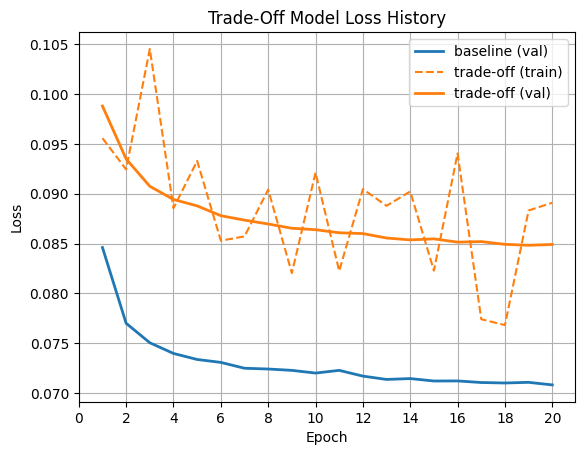

In [17]:
# plot baseeline validation loss
plot_experiment_history([base_loss], label_list = ['baseline'])

# plot training and validation losses for experiment 4 models
plot_experiment_history(
    [tradeoff_loss],
    label_list = ['trade-off'],
    color=plt.get_cmap('tab10').colors[1:],
    to_plot_train=True
)

# format plot
plt.grid()
plt.xticks(range(0, tradeoff_num_epoch + 1, 2))
plt.legend()
plt.title('Trade-Off Model Loss History')

# save plot
plt.savefig("/content/CAE-MNIST/outputs/tradeoff_model_files/tradeoff_image_loss.png")
plt.show()

In [18]:
#manually add and push trade_off loss curve image to Git repository
!git -C /content/CAE-MNIST add outputs/tradeoff_model_files/tradeoff_image_loss.png
!git -C /content/CAE-MNIST commit -m "Add trade-off model loss history curve"
!git -C /content/CAE-MNIST push origin main

[main 8a3cc03] Add trade-off model loss history curve
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/tradeoff_model_files/tradeoff_image_loss.png
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 46.31 KiB | 15.44 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   0ff4295..8a3cc03  main -> main


### 4.2 📷 Reconstruction Quality Analysis


In [19]:
# get sample images and labels
sample_images, sample_labels = get_image_samples(tradeoff_validation_dataloader)

# get reconstructed images from experiment 4
tradeoff_reconstructions=get_experiment_reconstructions([tradeoff_model], sample_images, device)

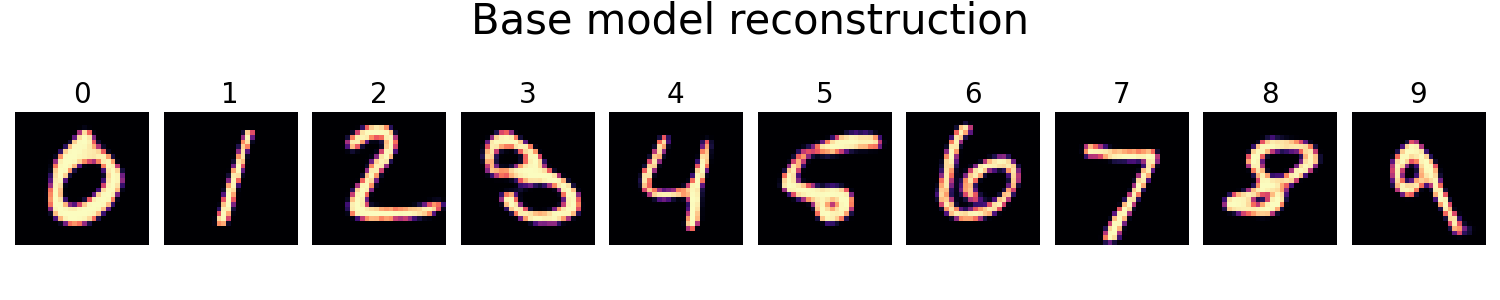

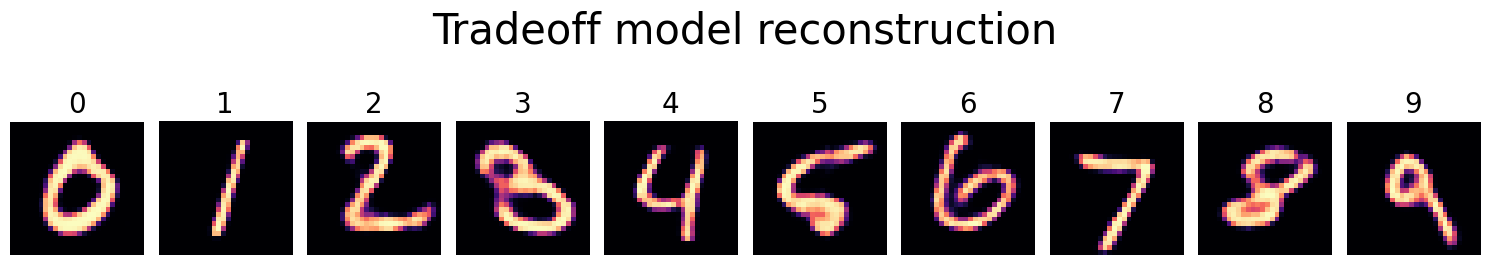

In [27]:
# display original benchmark images
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))
print('\n')

# display reconstructions from experiment
tradeoff_reconstruction_figures = plot_experiment_reconstructions(
    tradeoff_reconstructions,
    sample_labels,
    title_list=['Tradeoff model']
    )

tradeoff_reconstruction_figures[0].savefig("/content/CAE-MNIST/outputs/tradeoff_model_files/tradeoff_image_reconstruction.png")

In [28]:
!git -C /content/CAE-MNIST add outputs/tradeoff_model_files/tradeoff_image_reconstruction.png
!git -C /content/CAE-MNIST commit -m "Add trade-off reconstructed digits"
!git -C /content/CAE-MNIST push origin main

[main 260ca36] Add trade-off reconstructed digits
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite outputs/tradeoff_model_files/tradeoff_image_reconstruction.png (98%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 25.34 KiB | 6.33 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   2a10001..260ca36  main -> main


### 4.3 🧮 Model Complexity Analysis

In [26]:
# dictionary of model parameters in experiment 5
tradeoff_param_counts = {}

param_count = sum(p.numel() for p in tradeoff_model.parameters() if p.requires_grad)
tradeoff_param_counts['tradeoff_model'] = param_count

# print model paramets
print(tradeoff_param_counts)

{'tradeoff_model': 85649}


## 6. 📂 Export Trade-OFF Model Files

In [31]:
# Local (temporary) export folder
local_export_folder = '/content/CAE_tradeoff_model_local'
os.makedirs(local_export_folder, exist_ok=True)

# Save model weights
torch.save(tradeoff_model.state_dict(), os.path.join(local_export_folder, 'tradeoff_model.pth'))

# Save loss history
torch.save(tradeoff_loss, os.path.join(local_export_folder, 'tradeoff_loss.pth'))

# Save parameter counts dict
torch.save(tradeoff_param_counts, os.path.join(local_export_folder, 'tradeoff_param_counts.pth'))

# Save description
with open(os.path.join(local_export_folder, 'tradeoff_description.txt'), 'w') as f:
    f.write(tradeoff_description.strip())

In [32]:
# Paths
local_export_folder = '/content/CAE_tradeoff_model_local'
git_output_folder = '/content/CAE-MNIST/outputs/tradeoff_model_files'
files_to_copy = ['tradeoff_model.pth', 'tradeoff_loss.pth', 'tradeoff_param_counts.pth', 'tradeoff_description.txt']

# Copy all files to Git outputs folder (overwrite silently)
os.makedirs(git_output_folder, exist_ok=True)
for file in files_to_copy:
    shutil.copy2(os.path.join(local_export_folder, file),
                 os.path.join(git_output_folder, file))

# Commit and push
%cd /content/CAE-MNIST
!git add outputs/tradeoff_model_files/*
!git commit -m "Update tradeoff model files"
!git push origin main

/content/CAE-MNIST
[main c7eb1d8] Update tradeoff model files
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/tradeoff_model_files/tradeoff_param_counts.pth
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.70 KiB | 249.00 KiB/s, done.
Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   260ca36..c7eb1d8  main -> main


## Import Trade-Off Model Files

In [11]:
# Paths to files inside the cloned Git repo
outputs_path = '/content/CAE-MNIST/outputs/tradeoff_model_files'

# Load model
tradeoff_model = TradeoffAutoEncoder(
    n_channels=tradeoff_n_channels,
    latent_dim=tradeoff_latent_dim
).to(device)
tradeoff_model.load_state_dict(torch.load(os.path.join(outputs_path, 'tradeoff_model.pth'), map_location=device))
tradeoff_model.eval()

# Load loss history
tradeoff_loss = torch.load(os.path.join(outputs_path, 'tradeoff_loss.pth'))

# Load param counts dict
#tradeoff_param_counts = torch.load(os.path.join(outputs_path, 'tradeoff_param_counts.pth'))

# Load reconstructed images
#tradeoff_reconstruction = torch.load(os.path.join(outputs_path, 'tradeoff_reconstruction.pth'))

# Load description text
with open(os.path.join(outputs_path, 'tradeoff_description.txt'), 'r') as f:
    tradeoff_description = f.read()

print("✅ Trade-Off model, loss history, parameter counts, reconstructed images, and description loaded successfully.")


✅ Trade-Off model, loss history, parameter counts, reconstructed images, and description loaded successfully.


## Re-Clone Git Repository

In [ ]:
!rm -rf /content/CAE-MNIST
!git clone {repo_url}

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
fatal: could not create work tree dir 'CAE-MNIST': No such file or directory
